# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import math
pd.set_option('display.max_columns', None)
# Plot aesthetics
plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["figure.dpi"] = 120
sns.set_style("whitegrid")

# Loading the Data

In [2]:
df = pd.read_parquet("data/preprocessed/df_preprocessed.parquet")

# Statistics Descriptive

count        mean         std    min    25%     50%  \
units_sold          73100.0  136.464870  108.919406   0.00  49.00  107.00   
units_ordered       73100.0  110.004473   52.277448  20.00  65.00  110.00   
price               73100.0   55.135108   26.021945  10.00  32.65   55.05   
discount            73100.0   10.009508    7.083746   0.00   5.00   10.00   
competitor_pricing  73100.0   55.146077   26.191408   5.03  32.68   55.01   

                       75%     max  
units_sold          203.00  499.00  
units_ordered       155.00  200.00  
price                77.86  100.00  
discount             15.00   20.00  
competitor_pricing   77.82  104.94

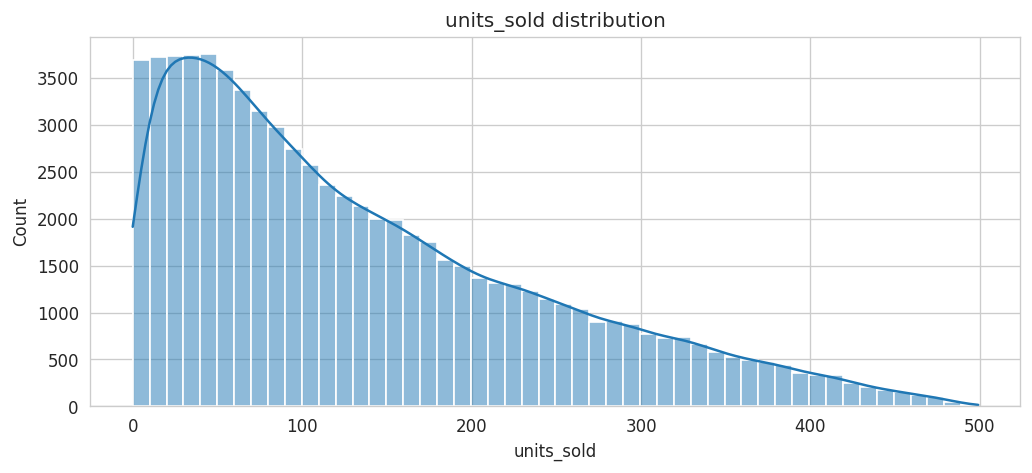

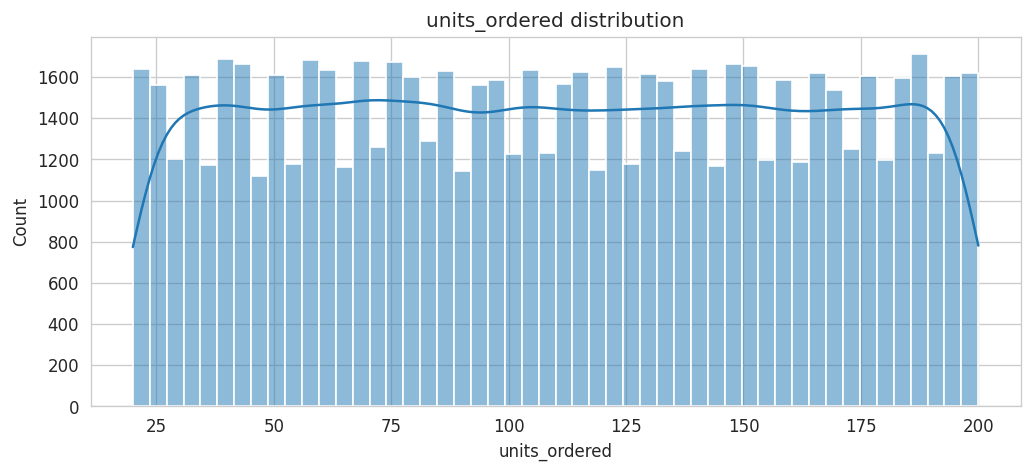

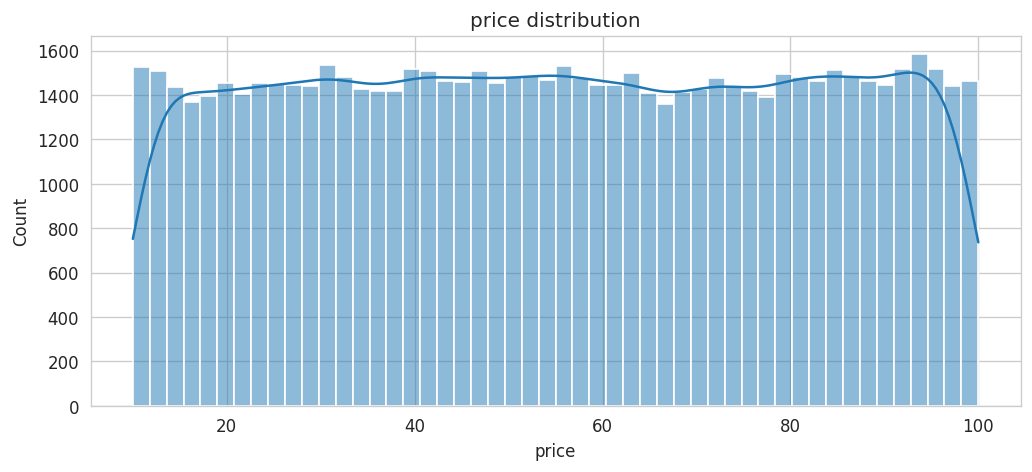

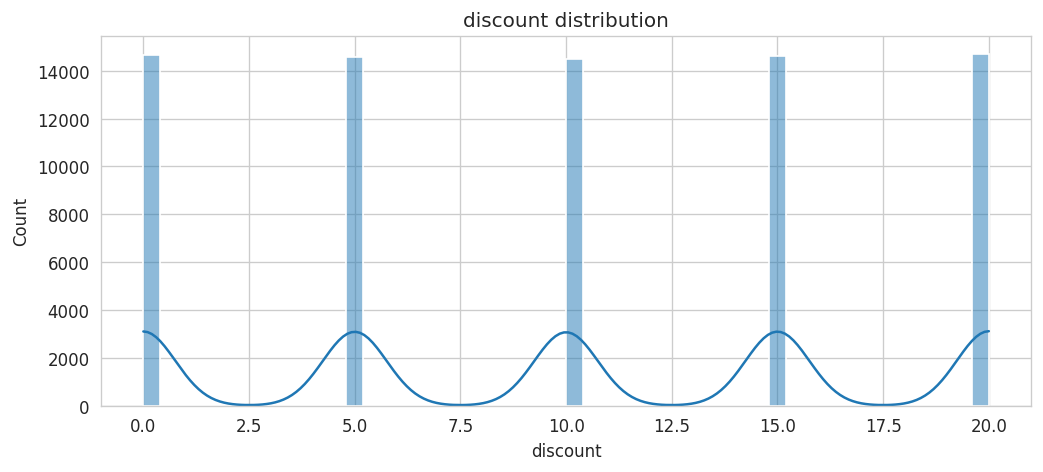

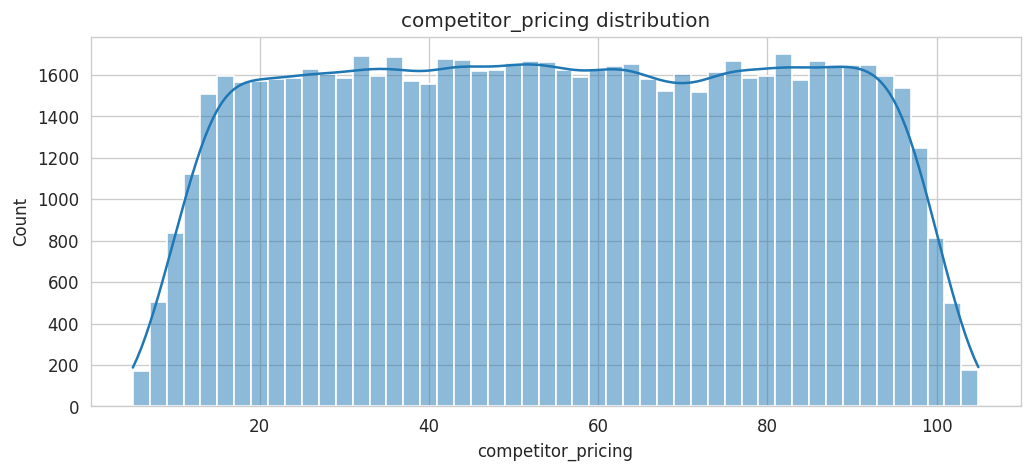

In [3]:
num_cols = ['units_sold',
       'units_ordered', 'price', 'discount', 'competitor_pricing']
display(df[num_cols].describe().T)

# Distribution plots
for col in num_cols:
    sns.histplot(df[col].dropna(), kde=True, bins=50)
    plt.title(f"{col} distribution")
    plt.show()

units_sold 
- berdistribusi right-skewed. Terdapat beberapa sales yang memiliki nilai tinggi
- **Action** : Check yang sales nya tinggi akibat promo/liburan

units_sold vs units_ordered
- units_sold max di 499 sedangkan units_ordered max di 499.
- **Action** : Cek ratio unit_sold/units_ordered > 1

price vs price_competitor
- Dari plotting untuk price vs price competitor tidak terlihat jauh berbeda
- **Action** : Tambahkan feature price_gap dan test korelasi dengan demand

# Rasio units_sold/units_ordered

In [4]:
# Hitung rasio sell_through
df["sell_through"] = df["units_sold"] / df["units_ordered"]

# Baris anomali: sell_through > 1
anomalous = df.query("sell_through > 1.0")
n_anom   = len(anomalous)
pct_anom = n_anom / len(df) * 100

print(f"{n_anom:,} baris (≈{pct_anom:.2f} %) memiliki sell_through > 1")


37,894 baris (≈51.84 %) memiliki sell_through > 1


In [5]:
# Tampilkan contoh 10 baris dengan rasio tertinggi
display(anomalous.sort_values("sell_through", ascending=False).head(10))


date store_id product_id     category region  inventory_level  \
72836 2023-04-13     S005      P0020  Electronics  South              491   
19685 2023-11-11     S002      P0007    Groceries   West              477   
59103 2023-09-16     S005      P0001         Toys   West              484   
35746 2023-10-21     S003      P0009    Groceries  South              469   
33681 2022-02-25     S003      P0007  Electronics  North              476   
14998 2023-01-14     S002      P0001    Groceries  South              485   
23420 2022-01-29     S002      P0013     Clothing   East              486   
34095 2023-04-15     S003      P0007  Electronics  North              445   
19149 2022-05-24     S002      P0007    Groceries   West              500   
24080 2023-11-20     S002      P0013     Clothing   East              472   

       units_sold  units_ordered  price  discount weather_condition  \
72836         467             20  53.92         5             Sunny   
19685         458             20  95.17         5             Rainy   
59103         454             20  22.81        15             Sunny   
35746         452             20  35.99        15            Cloudy   
33681         471             21  10.03        10             Snowy   
14998         445             20  33.87         5             Rainy   
23420         466             21  97.82        10             Snowy   
34095         443             20  30.07         0             Rainy   
19149         477             22  90.79        10             Sunny   
24080         466             22  91.39        15            Cloudy   

       holiday_promotion  competitor_pricing seasonality   series_id  \
72836              False               58.20      Summer  S005_P0020   
19685              False               99.37      Spring  S002_P0007   
59103               True               25.61      Summer  S005_P0001   
35746              False               35.59      Autumn  S003_P0009   
33681              False               12.06      Summer  S003_P0007   
14998              False               32.32      Spring  S002_P0001   
23420               True               95.29      Summer  S002_P0013   
34095               True               27.98      Summer  S003_P0007   
19149              False               93.51      Autumn  S002_P0007   
24080               True               91.05      Spring  S002_P0013   

       inventory_level_is_outlier  units_sold_is_outlier  \
72836                       False                   True   
19685                       False                   True   
59103                       False                   True   
35746                       False                   True   
33681                       False                   True   
14998                       False                  False   
23420                       False                   True   
34095                       False                  False   
19149                       False                   True   
24080                       False                   True   

       units_ordered_is_outlier  price_is_outlier  discount_is_outlier  \
72836                     False             False                False   
19685                     False             False                False   
59103                     False             False                False   
35746                     False             False                False   
33681                     False             False                False   
14998                     False             False                False   
23420                     False             False                False   
34095                     False             False                False   
19149                     False             False                False   
24080                     False             False                False   

       competitor_pricing_is_outlier  sell_through  
72836                          False     23.350000  
19685  

-  37 894 baris (≈ 51,8 %) menunjukkan `sell_through` > 1, artinya jumlah unit *terjual* melebihi unit *diorder* pada baris yang sama
- **Contoh ekstrem** mencapai rasio 23×
- **Action** : Fitur `units_ordered` mungkin tidak cukup kuat untuk memprediksi `units_sold`

# `price_gap` vs `unit_sold`

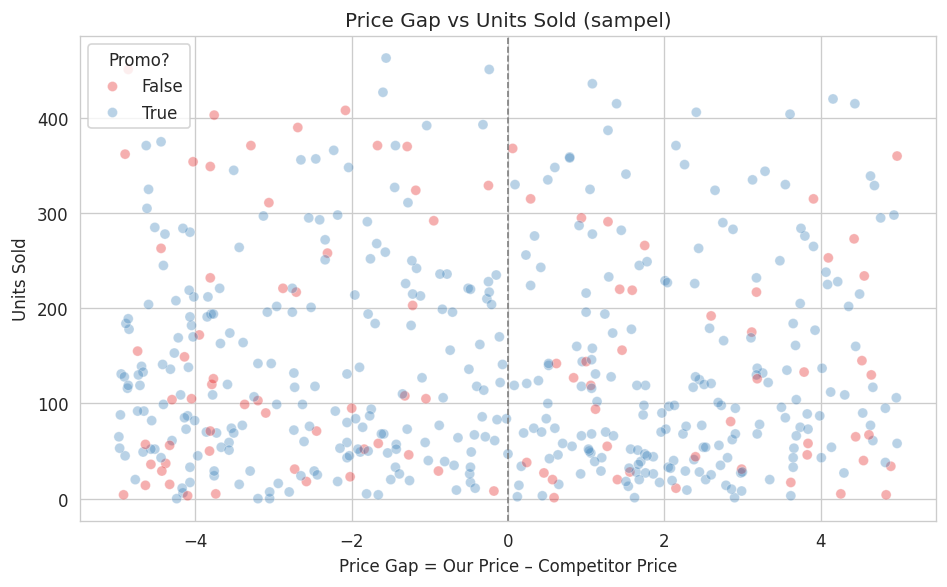

Korelasi Pearson price_gap vs units_sold: -0.002
Korelasi Pearson discount vs units_sold: 0.003


In [6]:
# Buat fitur price_gap & flag promo
df["price_gap"] = df["price"] - df["competitor_pricing"]
df["is_promo"]  = df["discount"] > 0   # Boolean flag

# Ambil sampel agar plot tetap ringan
SAMPLE_N = min(500, len(df))
plot_df  = df.sample(SAMPLE_N, random_state=42)

plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=plot_df,
    x="price_gap",
    y="units_sold",
    hue="is_promo",
    palette="Set1",
    alpha=0.35
)
plt.axvline(0, ls="--", lw=1, color="gray")
plt.title("Price Gap vs Units Sold (sampel)")
plt.xlabel("Price Gap = Our Price – Competitor Price")
plt.ylabel("Units Sold")
plt.legend(title="Promo?")
plt.tight_layout()
plt.show()

# Korelasi sederhana
corr = df[["price_gap", "units_sold"]].corr().iloc[0, 1]
print(f"Korelasi Pearson price_gap vs units_sold: {corr:.3f}")
corr = df[["discount", "units_sold"]].corr().iloc[0, 1]
print(f"Korelasi Pearson discount vs units_sold: {corr:.3f}")

- Tidak terlihat pola linear pada `price_gap` dan `unit_sold`(titik tersebar)
- Korelasi mendekati nilai 0 yang artinya tidak ada hubungan linear antara selisih harga dan jumlah terjual
- Titik warna biru (promo) dan merah (non-promo) terdistribusi acak, selain itu korelasi pearson `discount` & `unit_sold` mendekati titik 0 yang artinya tidak ada hubungan linear

# Zero Sales vs Stock Out

In [7]:
# Tandai baris bersalas 0
zero_sales = df["units_sold"] == 0
stockout   = (df["inventory_level"] == 0) & zero_sales
demand_zero = (df["inventory_level"] > 0) & zero_sales

print(f" Penjualan 0 total: {zero_sales.sum():,} baris")
print(f"   • Penjualan 0 + stok 0  : {stockout.sum():,} baris  ({stockout.mean()*100:.2f} %)")
print(f"   • Penjualan 0 + stok >0 : {demand_zero.sum():,} baris  ({demand_zero.mean()*100:.2f} %)")

# Tampilkan contoh baris
cols_show = ["date", "series_id", "units_sold", "inventory_level", "sell_through"]
display(df.loc[stockout].head(5))
display(df.loc[demand_zero].head(5))

 Penjualan 0 total: 360 baris
   • Penjualan 0 + stok 0  : 0 baris  (0.00 %)
   • Penjualan 0 + stok >0 : 360 baris  (0.49 %)


Empty DataFrame
Columns: [date, store_id, product_id, category, region, inventory_level, units_sold, units_ordered, price, discount, weather_condition, holiday_promotion, competitor_pricing, seasonality, series_id, inventory_level_is_outlier, units_sold_is_outlier, units_ordered_is_outlier, price_is_outlier, discount_is_outlier, competitor_pricing_is_outlier, sell_through, price_gap, is_promo]
Index: []

date store_id product_id   category region  inventory_level  \
120 2022-05-01     S001      P0001  Groceries  North              125   
251 2022-09-09     S001      P0001  Groceries  North              220   
492 2023-05-08     S001      P0001  Groceries  North              135   
605 2023-08-29     S001      P0001  Groceries  North              105   
887 2022-06-06     S001      P0002       Toys  South               72   

     units_sold  units_ordered  price  discount weather_condition  \
120           0            117  36.91        10            Cloudy   
251           0            102  38.45        20             Sunny   
492           0             66  94.08         5             Sunny   
605           0            163  39.32         5             Rainy   
887           0            117  95.64        15             Snowy   

     holiday_promotion  competitor_pricing seasonality   series_id  \
120              False               37.85      Spring  S001_P0001   
251               True               39.51      Winter  S001_P0001   
492              False               91.55      Autumn  S001_P0001   
605              False               40.58      Spring  S001_P0001   
887               True               92.28      Spring  S001_P0002   

     inventory_level_is_outlier  units_sold_is_outlier  \
120                       False                  False   
251                       False                  False   
492                       False                  False   
605                       False                  False   
887                       False                  False   

     units_ordered_is_outlier  price_is_outlier  discount_is_outlier  \
120                     False             False                False   
251                     False             False                False   
492                     False             False                False   
605                     False             False                False   
887                     False             False                False   

     competitor_pricing_is_outlier  sell_through  price_gap  is_promo  
120                          False           0.0      -0.94      True  
251                          False           0.0      -1.06      True  
492                          False           0.0       2.53      True  
605                          False           0.0      -1.26      True  
887                          False           0.0       3.36      True

- Semua penjualan 0 dikarenakan tidak ada demand (bukan stockout)

# Corellation Analysis

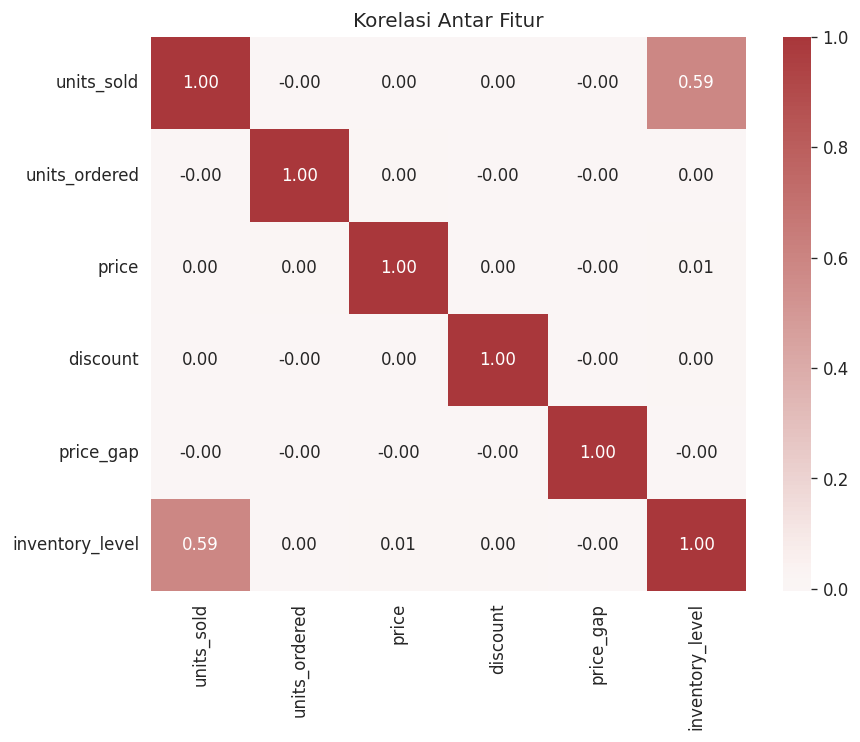

In [8]:
# Korelasi antar fitur
feat_cols = ["units_sold", "units_ordered", "price", "discount", "price_gap", "inventory_level"]
corr_feats = df[feat_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_feats, annot=True, fmt=".2f", cmap="vlag", center=0)
plt.title("Korelasi Antar Fitur")
plt.show()


- **`units_sold` vs `inventory_level` (r = 0.59)**  
  Terdapat korelasi positif cukup kuat antara inventory_level dan units_sold.  
  *notes:* Korelasi ini bisa timbul karena stok diatur berdasarkan permintaan historis, bukan stok yang memicu penjualan.

* **`units_sold` vs `price`, `discount`, `price_gap` (|r| < 0.05)**  
  Tidak ada korelasi linear antara units_sold terhadap price, discount dan price_gap

* **`units_sold` vs `units_ordered` (r ≈ 0)**  
  Tidak ada korelasi linier

In [9]:
# Untuk fitur categorical
def correlation_ratio(categories, values):
    cat = pd.Categorical(categories)
    y = np.asarray(values)
    grand_mean = y.mean()
    ss_between = sum(len(y[cat == k]) * (y[cat == k].mean() - grand_mean)**2
                     for k in cat.categories)
    ss_total   = ((y - grand_mean)**2).sum()
    return np.sqrt(ss_between / ss_total) if ss_total else 0.0

# hitung η untuk beberapa fitur kategori
for col in ["category", "region", "seasonality", 'weather_condition', 'holiday_promotion']:
    eta = correlation_ratio(df[col], df["units_sold"])
    print(f"η({col} ➜ units_sold) = {eta:.3f}")

η(category ➜ units_sold) = 0.006
η(region ➜ units_sold) = 0.005
η(seasonality ➜ units_sold) = 0.008
η(weather_condition ➜ units_sold) = 0.010
η(holiday_promotion ➜ units_sold) = 0.000


- Semua fitur categorical memiliki korelasi yang lemah terhadap `unit_sold`

# Time Series Plot

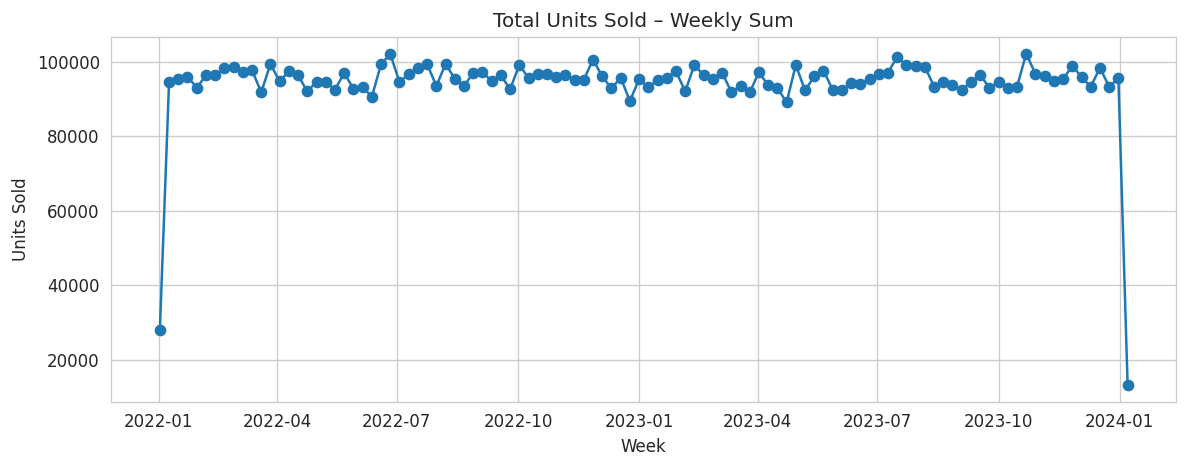

In [10]:
# Plot keseluruhan
weekly_total = (
    df.set_index('date')
      .resample('W')['units_sold']
      .sum()
)

plt.figure(figsize=(10, 4))
plt.plot(weekly_total.index, weekly_total.values, marker='o')
plt.title("Total Units Sold – Weekly Sum")
plt.xlabel("Week")
plt.ylabel("Units Sold")
plt.tight_layout()
plt.show()

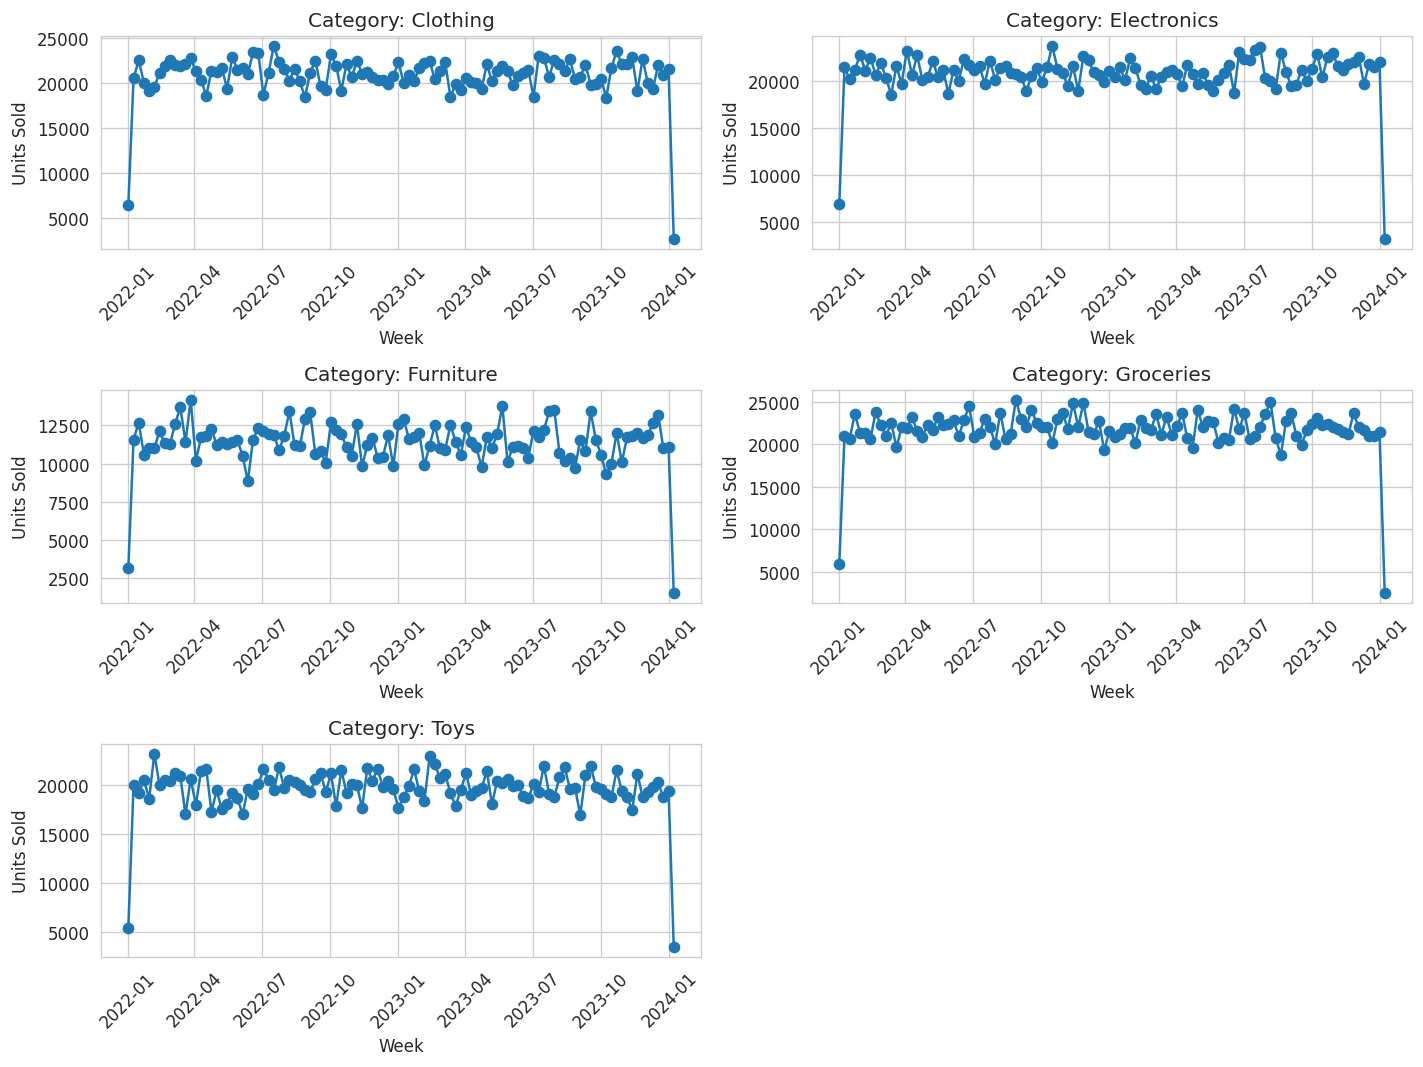

In [11]:
# plot per kategori
weekly_cat = (
    df.set_index('date')
      .groupby('category')['units_sold']
      .resample('W')
      .sum()
      .reset_index()
)

cats = weekly_cat['category'].unique()
n = len(cats)
cols = 2  
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 3), sharey=False)
axes = axes.flatten()

for ax, cat in zip(axes, cats):
    subset = weekly_cat[weekly_cat['category'] == cat]
    ax.plot(subset['date'], subset['units_sold'], marker='o')
    ax.set_title(f"Category: {cat}")
    ax.set_xlabel("Week")
    ax.set_ylabel("Units Sold")
    ax.tick_params(axis='x', rotation=45)


for ax in axes[len(cats):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

- Pada minggu pertama 2022 dan minggu awal 2024 terdapat penurunan tajam <10K
- Volatilitas mingguan tidak tinggi


In [12]:
# Fungsi utk boxplot
def annotated_boxplot(data_list, labels, title, ylabel="Units Sold"):
    fig, ax = plt.subplots(figsize=(8, 5))
    bp = ax.boxplot(data_list, labels=labels, showfliers=False)
    ax.set_title(title, fontsize=14, weight='bold')
    ax.set_ylabel(ylabel)
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    # Annotate medians
    medians = [np.median(d) for d in data_list]
    for i, median in enumerate(medians, start=1):
        ax.text(i, median, f"{median:,.0f}", ha='center', va='bottom', fontsize=9, weight='bold')
    plt.tight_layout()
    plt.show()


/tmp/ipykernel_4103736/241557576.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_list, labels=labels, showfliers=False)


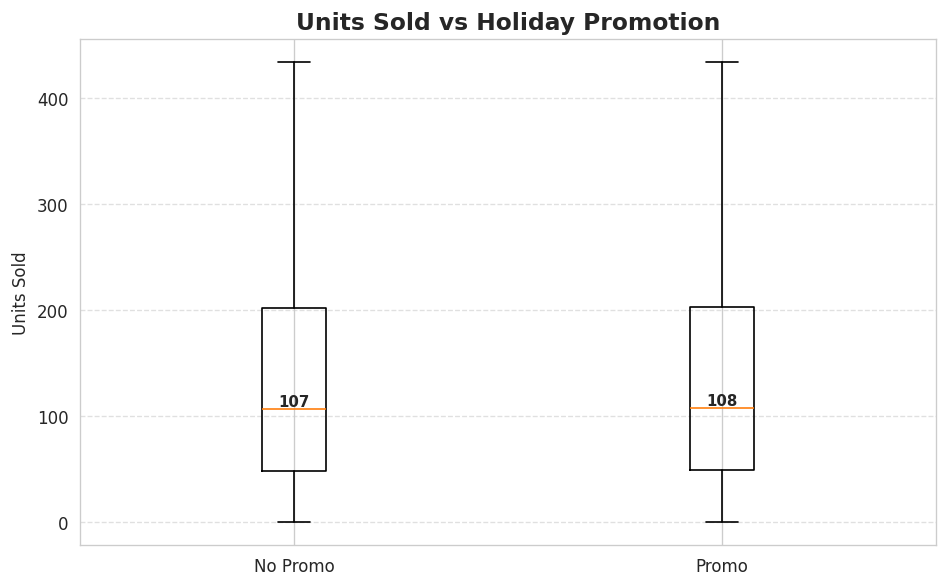

In [13]:
# holiday boxplot
holiday_labels = ['No Promo', 'Promo']
holiday_data = [
    df.loc[df['holiday_promotion'] == False, 'units_sold'],
    df.loc[df['holiday_promotion'] == True,  'units_sold']
]
annotated_boxplot(holiday_data, holiday_labels, "Units Sold vs Holiday Promotion")

/tmp/ipykernel_4103736/241557576.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_list, labels=labels, showfliers=False)


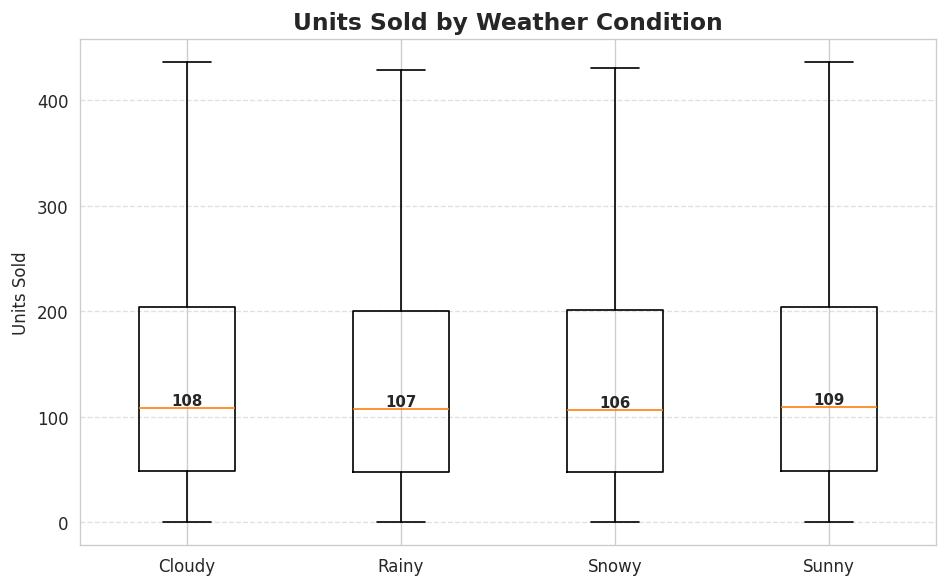

In [14]:
# Weather boxplot
weather_labels = sorted(df['weather_condition'].dropna().unique())
weather_data = [df.loc[df['weather_condition'] == w, 'units_sold'] for w in weather_labels]
annotated_boxplot(weather_data, weather_labels, "Units Sold by Weather Condition")

In [ ]:
# Seasonality Boxplot
season_labels = sorted(df['seasonality'].dropna().unique())
season_data = [df.loc[df['seasonality'] == s, 'units_sold'] for s in season_labels]
annotated_boxplot(season_data, season_labels, "Units Sold by Season")

/tmp/ipykernel_4103736/241557576.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_list, labels=labels, showfliers=False)


- Tidak ada perbedaan yang signifikan di masing2 kategori terhadap `units_sold`
- Dalam dataset ini, promo liburan, cuaca dan musim hanyalah weak signals

# Calendar heat-maps & seasonality

# STL decomposition

# Stationary Test

# Group-level summaries (Mean, median, cv, etc by group)

# Time Series Clustering